# Applied Deep Learning Tutorial 

contact: Mark.schutera@kit.edu


# Generative Adversarial Neural Networks (GANs)

## Introduction
In this tutorial, you will attempt to implement a Generative Adversarial Neural Network for image generation on the MNIST dataset. Labeled training data is the fuel for supervised machine learning approaches. Thus GANs can be seen as the holy grail when it comes to generating additional data affiliated with a given source domain. GANs have first been introduced by [Goodfellow et al.](http://arxiv.org/abs/1406.2661)

<img src="graphics/stormtrooper.jpg" width="700"><br>
<center> Fig. 1: Stormtrooper reflects the idea of generating multiple instances of the same source domain. </center>


## Introduction 

GANs are based on a joint training of at least two separate neural networks. The generator and the discriminator.
The generator takes an input, most often a latent random input, and maps this input to an output with the dimensions of a source domain sample, meaning real-world data. The discriminator takes inputs from either the source domain or the generator. The discriminator then does a binary classification, learning to distinguish between generated and real samples.

<img src="graphics/GANarchitecture.jpg" width="700"><br>
<center> Fig. 2: Overview of a simple GAN architecture with discriminator and generator. </center>

The training process happens in two passes. During the first pass the generator is frozen, and the discriminator is trained to distinguish between real and generated samples. 
In the second pass, the discriminator is frozen and the generator is trained using the discriminator classification as objective, backpropagating the error. 
By iteratively repeating those two passes, the quality of the generated samples increases, while the ability of the discriminator of distinguishing between real and generated improves too.


# Build your GAN

Do the necessary imports.
And load the [MNIST](http://yann.lecun.com/exdb/mnist/) data set - the hello world for machine learning.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

%tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import MNIST data

import input_data

mnist = input_data.read_data_sets('/content/drive/My Drive/Colab Notebooks/ADL_10_Tutorial_Schutera/data/', one_hot=True)


Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /content/drive/My Drive/Colab Notebooks/ADL_10_Tutorial_Schutera/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /content/drive/My Drive/Colab Notebooks/ADL_10_Tutorial_Schutera/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /content/drive/My Drive/Colab Notebooks/ADL_10_Tutorial_Schutera/data/t10k-images-idx3-ubyte.gz
Extracting /content/drive/My Drive/Colab Notebooks/ADL_10_Tutorial_Schutera/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


In [4]:
# Import MNIST data

#import input_data

mnist = input_data.read_data_sets('/content/drive/My Drive/Colab Notebooks/ADL_10_Tutorial_Schutera/data/', one_hot=True)


Extracting /content/drive/My Drive/Colab Notebooks/ADL_10_Tutorial_Schutera/data/train-images-idx3-ubyte.gz
Extracting /content/drive/My Drive/Colab Notebooks/ADL_10_Tutorial_Schutera/data/train-labels-idx1-ubyte.gz
Extracting /content/drive/My Drive/Colab Notebooks/ADL_10_Tutorial_Schutera/data/t10k-images-idx3-ubyte.gz
Extracting /content/drive/My Drive/Colab Notebooks/ADL_10_Tutorial_Schutera/data/t10k-labels-idx1-ubyte.gz


## Setting up dimensions and initialization

- Determine and define the image dimension, which for MNIST, as we know by now, is 28x28 Pixels, this is the number of inputs to the discriminator.
- The input to the generator will be a random latent variable, the more inputs and thus combinations we allow here, the more variance our generated samples will show.
- Next we will define the dimension (number of neurons) of our hidden layer for the generator network and the discriminator network. Both have one hidden layer, and should be approximately equally complex to keep the balance between the two networks.


In [0]:
# Network Params
image_dim = 784 # 28*28 pixels
gen_hidden_dim = 256
disc_hidden_dim = 256
noise_dim = 100 

In [0]:
# Define placeholders for the inputs
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
disc_input = tf.placeholder(tf.float32, shape=[None, image_dim], name='disc_input')

## Glorot initialization

We will initialize our weight with the Glorot initialization which was presented in this [paper](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). 

In [0]:
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

## Setting up parameters
Initialize the weights with the Glorot initializer. And initialize the biases as zeroes.

##### Why can we initialize the bias as zeroes?

In [0]:
# Store layers weight & bias for discriminator and generator
weights = {
    'gen_hidden1': tf.Variable(glorot_init([noise_dim, gen_hidden_dim])),
    'gen_out': tf.Variable(glorot_init([gen_hidden_dim, image_dim])),
    
    'disc_hidden1': tf.Variable(glorot_init([image_dim, disc_hidden_dim])),
    'disc_out': tf.Variable(glorot_init([disc_hidden_dim, 1])),
}
biases = {
    'gen_hidden1': tf.Variable(tf.zeros([gen_hidden_dim])),
    'gen_out': tf.Variable(tf.zeros([image_dim])),
    
    'disc_hidden1': tf.Variable(tf.zeros([disc_hidden_dim])),
    'disc_out': tf.Variable(tf.zeros([1])),
}

## Designing the Generator

The Generator will be designed as a Fully Connected Neural Network (FCN). Starting from our input x implement the following operations: 
- first we multiply the inputs (first layer) with the weights of the hidden layer.
- add the biases.
- map the output with the ReLU activation function.
- mulitply the output of the hidden layer with the weights of the output layer.
- add the biases.
- map the output with the Sigmoid activation function.

###### Why is the activation function of the output layer realized as sigmoid function?


In [0]:
# Generator
def generator(x):
    hidden_layer1 = tf.matmul(x, weights['gen_hidden1'])
    hidden_layer1 = tf.add(hidden_layer1, biases['gen_hidden1'])
    hidden_layer1 = tf.nn.relu(hidden_layer1)
    
    out_layer = tf.matmul(hidden_layer1, weights['gen_out'])
    out_layer = tf.add(out_layer, biases['gen_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

## Designing the Discriminator

The discriminator will be designed similar to the generator: 
- first we multiply the inputs (first layer) with the weights of the hidden layer.
- add the biases.
- map the output with the ReLU activation function.
- mulitply the output of the hidden layer with the weights of the output layer.
- add the biases.
- map the output with the Sigmoid activation function.

###### Why is the activation function of the output layer realized as sigmoid function?

We need to map our output to a range of values between 0 and 1 or source or generated for binary classification. This nicely is reflected by the range of values of the sigmoid function.

###### Why is the discriminator architecture so similar to the generator? Discuss complexity of the two models with respect to their task.

We need both models to be similar complex to make an iterative interplay possible. If one model would have a peak in performance improvement it might happen, that the other model wouldn't be able to benefit from the feedback of the other model anymore. Thus the complexity of the models should be chosen similar. 
Yet the discriminator has a slightly easier task, doing a binary classification - it is thus adviced to sometimes handicap this model by limitting the complexity or the learning rate.

In [0]:
# Discriminator
def discriminator(x):
    hidden_layer1 = tf.matmul(x, weights['disc_hidden1'])
    hidden_layer1 = tf.add(hidden_layer1, biases['disc_hidden1'])
    hidden_layer1 = tf.nn.leaky_relu(hidden_layer1, alpha=0.2)

    out_layer = tf.matmul(hidden_layer1, weights['disc_out'])
    out_layer = tf.add(out_layer, biases['disc_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

## Discriminator Training

The discriminator is trained on both, samples from source domain and from the generated domain. 


In [0]:
# Build the pipelines for the discriminator network inference

# sample from source
disc_real = discriminator(disc_input)

# sample from generator
disc_fake = discriminator(generator(gen_input))

## Objective Function - Min Max Game

The loss for the discriminator is as follows:
\begin{align}
    -\log_{10}(discriminator_{real})-\log_{10}(1-discriminator_{fake})
\end{align}

For better understanding lets assume a generated sample. When feeding the generated sample into the discriminator and the discriminator is able to detect the domain, the sigmoid output will be a value around 0. The loss should thus be low in this case. We achieve this by capsuling the discriminator output as: 

$\log_{10}(1-discriminator_{fake})$.

- If the generated image is detected as such, the loss will be $-\log(1-(0))=-\log(1)$ and thus tending to become 0. 
- If the generated image is detected as source image, the loss will be $-\log(1-(1))=-\log(0)$ and thus tending to become inifite large. 

**Elaborate the loss for a real image given to the discriminator**

When feeding the ***mnist data*** into the discriminator and the discriminator is able to detect the real data, the sigmoid output will be a value around 1. The loss should thus be low in this case. We achieve this by capsuling the discriminator output as: 

$\log_{10}(discriminator_{real})$.

- If the source image is detected as such,  the loss will be $-\log(1)$ and thus tending to become 0.
- If the source image is detected as generated image, the loss will be $-\log(0)$ and thus tending to become inifite large.

**Elaborate the loss for the generator**

When feeding the **generated sample** into the discriminator and the discriminator detect that as real data, the sigmoid output will be a value around 0. The loss should thus be low in this case. We achieve this by capsuling the discriminator output as: 

$\log_{10}(discriminator_{fake})$.

- If the generated image is detected as such,  the **generator** loss will be  $-\log(0)$ and thus tending to become inifite large.
- If the generated image is detected as source image,  the **generator** loss will be  $-\log(1)$ and thus tending to become 0.

The loss is determined over multiple samples, thus the mean output of the models is considered

In [0]:
# Build Loss
gen_loss = -tf.reduce_mean(tf.log(disc_fake))
disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1. - disc_fake))

## Setting up the Training and Optimizer

Set up the optimizer as Adam optimizer.


In [0]:
# Build Optimizers

learning_rate = 0.0002

optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Two Pass Training

In Tensorflow by default each optimizer updateds all variables, but in this special architecture we need either two update on the generator or the discriminator only. 

Therefore we define the two passes as separate optimization tasks, while defining the according variables that are affiliated to the pass. 

In [0]:
gen_vars = [weights['gen_hidden1'], weights['gen_out'],
            biases['gen_hidden1'], biases['gen_out']]
disc_vars = [weights['disc_hidden1'], weights['disc_out'],
            biases['disc_hidden1'], biases['disc_out']]
'''
minimize(gen_loss, var_list=gen_vars) add operations to minimize loss by updating var_list.
This method simply combines calls compute_gradients()(Compute gradients of loss for the variables in var_list) 
and apply_gradients()(Apply gradients to variables)
'''
train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)

## Start the Training

In [15]:
# Training Params (feel free to mess around with the hyperparameters)
num_steps = 70000
batch_size = 128

sess = tf.Session()
sess.run(tf.global_variables_initializer())

g_loss = []
d_loss = []

for i in range(1, num_steps+1):
    
    # Get batch from MNIST dataset
    batch_x, _ = mnist.train.next_batch(batch_size)

    # Generate latent random variable to feed to the generator, by drawing from a uniform distribution 
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])

    # Train
    feed_dict = {disc_input: batch_x, gen_input: z}
    _, _, gl, dl = sess.run([
                             train_gen, 
                             train_disc, 
                             gen_loss, 
                             disc_loss
                            ],
                            feed_dict=feed_dict)

    g_loss.append(gl)
    d_loss.append(dl)

    if i % 200 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
        
    # print('Training finished.')

Step 1: Generator Loss: 0.257261, Discriminator Loss: 1.963373
Step 200: Generator Loss: 3.095629, Discriminator Loss: 0.212889
Step 400: Generator Loss: 2.733717, Discriminator Loss: 0.229985
Step 600: Generator Loss: 3.156853, Discriminator Loss: 0.125917
Step 800: Generator Loss: 3.280975, Discriminator Loss: 0.113432
Step 1000: Generator Loss: 3.597487, Discriminator Loss: 0.086635
Step 1200: Generator Loss: 3.743783, Discriminator Loss: 0.071219
Step 1400: Generator Loss: 4.268270, Discriminator Loss: 0.052655
Step 1600: Generator Loss: 4.172303, Discriminator Loss: 0.062914
Step 1800: Generator Loss: 4.310455, Discriminator Loss: 0.041958
Step 2000: Generator Loss: 4.326652, Discriminator Loss: 0.046468
Step 2200: Generator Loss: 4.034064, Discriminator Loss: 0.042707
Step 2400: Generator Loss: 4.514466, Discriminator Loss: 0.030598
Step 2600: Generator Loss: 4.734303, Discriminator Loss: 0.015251
Step 2800: Generator Loss: 4.325957, Discriminator Loss: 0.038826
Step 3000: Genera

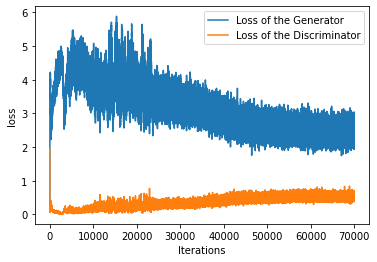

In [16]:
# Plot visualization of the losses, you should pay close attention.
plt.plot(g_loss, label='Loss of the Generator')
plt.plot(d_loss, label='Loss of the Discriminator')
plt.xlabel('Iterations')
plt.ylabel('loss')
plt.legend()
plt.show()

The loss visualization tells us a lot about the training process. 
- Make sure the discriminator does have a continuous loss
- The generator loss should continuously decrease

##### Why do we only load the MNIST images and not the groundtruth? 
The GAN does not care for class labels, and the domain labels are already given by the pipeline.


## Taking the Generator for a ride.

After training the generator, we do a visual check of the generated samples.

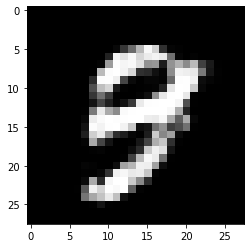

In [17]:
# Testing
# Generate images from a latent random variable, using the generator network.
# first we will create an empty np.array with the size of 28x28 
canvas = np.empty((28, 28))

# We will generate the latent random variable drawing from the uniform distribution in [-1, 1] as a 1x100 tensor
z = np.random.uniform(-1., 1., size=[1, noise_dim])

# we will now feed z as input to the generator
g = sess.run(generator(gen_input), feed_dict={gen_input: z})

# The generated sample is reshaped and visualized.
canvas[0:28, 0:28] = g[0].reshape([28, 28])

plt.figure()
plt.imshow(canvas, cmap="gray")
plt.show()

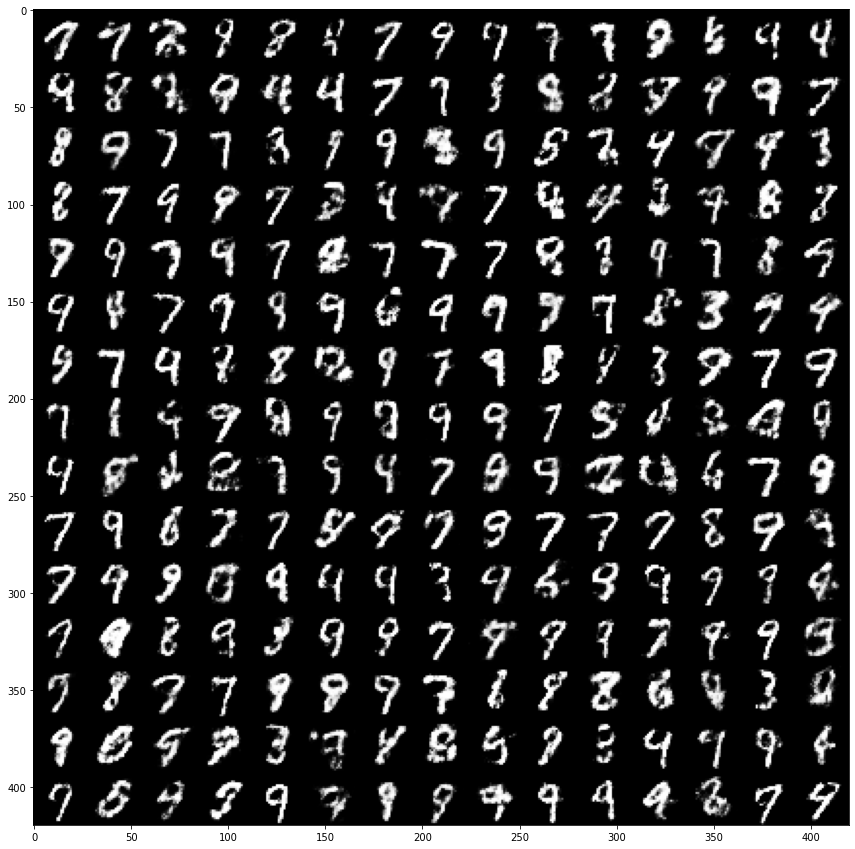

In [18]:
# Generate n*n images from noise, using the generator network.
n = 15
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    z = np.random.uniform(-1., 1., size=[n, noise_dim])
    # Generate image from noise.
    g = sess.run(generator(gen_input), feed_dict={gen_input: z})

    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()

## Next steps to take it from here

- We can notice that some digits are generated more frequent than others, why is that. Implement an approach that does solve this issue or at least weaken the effect.
- So far we have only evaluated the performance of the generator qualitatively. How could a quantitative evaluation look like? Implement a quantitative evaluation.


# Next Steps

Ich kenne mich leider nicht so gut aus mit dem reinem TensorFlow aus. Deswegen habe ich den MNIST-GAN mit Keras nachgebaut und habe mit den unterschiedlichen Parametern experimentiert.

Die beste Ergebnisse habe ich bei der Anwendung der folgenden Hyperparameter/Techniken erreicht:

* Batch Size 128
* Adam Optimizer (lr = 0.0002, beta1 = 0.5)
* Label Smoothing (0.1 für fake, 0.9 für real)
* Batch Normalization
+ LeakyReLU(alpha=0.2) im Discriminator

Dadurch konnte ich die den Mode Collaps reduzieren

(Als Evaluation hätte ich gerne Kullback-Leibler Divergenz oder Frechet Distance zwischen den realen und den generierten Bildern ausprobiert. Das ist aber in Rahmen dieser Hausafgabe noch nicht implementiert.)



# MNIST-GAN (implementiert mit Keras)

In [1]:

%tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.optimizers import Adam
#from tensorflow.keras.layers import *
from keras.layers import Dense, Activation, Input, LeakyReLU, ReLU, Reshape, Flatten, MaxoutDense, BatchNormalization
import numpy as np

(X_train, _), (_, _) = mnist.load_data()

# normalise data
X_train = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
image_dim = (X_train.shape[1], X_train.shape[2])
res = X_train.shape[1] * X_train.shape[2]
noise_dim = int(res / 4)

gen_input = Input(shape=(noise_dim,))

# Build Generator
def build_generator(noise_dim, res):
  generator = Sequential()
  generator.add(Dense(int(res/4), input_shape=(noise_dim,)))
  generator.add(ReLU())
  generator.add(BatchNormalization())
  generator.add(Dense(int(res/2)))
  generator.add(ReLU())
  generator.add(BatchNormalization())
  generator.add(Dense(int(res)))
  generator.add(ReLU())
  generator.add(MaxoutDense(res))
  generator.add(Reshape(image_dim))
  generator.summary()

  return generator


# Build Descriminator
def build_descriminator(image_dim, res):
  descriminator = Sequential()
  descriminator.add(Flatten(input_shape=image_dim))
  descriminator.add(Dense(int(res/2)))
  descriminator.add(LeakyReLU(alpha=0.2))
  descriminator.add(BatchNormalization())
  descriminator.add(Dense(int(res/4)))
  descriminator.add(LeakyReLU(alpha=0.2))
  descriminator.add(Dense(int(res/8)))
  descriminator.add(LeakyReLU(alpha=0.2))

  descriminator.add(Dense(1, activation='sigmoid'))
  descriminator.summary()

  return descriminator

generator = build_generator(noise_dim, res)
descriminator = build_descriminator(image_dim, res)
gan = Model(gen_input, descriminator(generator(gen_input)))


descriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
descriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/keras/legacy/layers.py:74: UserWarning: The `MaxoutDense` layer is deprecated and will be removed after 06/2017.
  warnings.warn('The `MaxoutDense` layer is deprecated '


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 196)               38612     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 196)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 196)               784       
_________________________________________________________________
dense_2 (Dense)              (None, 392)               77224     
_________________________________________________________________
re_lu_2 (ReLU)               (None, 392)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 392)               1568      
_________________________________________________________________
dense_3 (Dense)              (None, 784)              

In [3]:
epochs = 70000
batch_size = 128
half_batch_size = int(batch_size / 2)
g_loss = []
d_loss = []

for i in range(epochs):
    # get half the batch from real images
    real_idxs = np.random.randint(X_train.shape[0], size=half_batch_size)
    real_imgs = X_train[real_idxs]
    
    # get other half of generated images
    noise = np.random.normal(size=(half_batch_size, noise_dim))
    #noise = np.random.uniform(-1., 1., size=[half_batch_size, noise_dim])
    fake_imgs = generator.predict(noise)
    
    # train discriminator
    #rloss = descriminator.train_on_batch(real_imgs, np.ones(half_batch_size))
    #floss = descriminator.train_on_batch(fake_imgs, np.zeros(half_batch_size))
    rloss = descriminator.train_on_batch(real_imgs, np.full(half_batch_size, 0.9))
    floss = descriminator.train_on_batch(fake_imgs, np.full(half_batch_size, 0.1))
    dloss = 0.5 * np.add(rloss, floss)

    # train generator
    # first, generate images and classify them via discriminator
    noise = np.random.normal(size=(batch_size, noise_dim))
    gloss = gan.train_on_batch(noise, np.ones(batch_size,))

    g_loss.append(gloss[0])
    d_loss.append(dloss[0])

    if i % 2000 == 0:
      print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gloss[0], dloss[0]))
    

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step 0: Generator Loss: 1.100785, Discriminator Loss: 0.833471


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step 2000: Generator Loss: 1.353411, Discriminator Loss: 0.536205
Step 4000: Generator Loss: 1.274310, Discriminator Loss: 0.556879
Step 6000: Generator Loss: 1.746534, Discriminator Loss: 0.529365
Step 8000: Generator Loss: 1.754917, Discriminator Loss: 0.495747
Step 10000: Generator Loss: 1.652354, Discriminator Loss: 0.587562
Step 12000: Generator Loss: 1.582631, Discriminator Loss: 0.548612
Step 14000: Generator Loss: 1.248130, Discriminator Loss: 0.532543
Step 16000: Generator Loss: 1.537740, Discriminator Loss: 0.541231
Step 18000: Generator Loss: 1.795938, Discriminator Loss: 0.511465
Step 20000: Generator Loss: 1.573254, Discriminator Loss: 0.591323
Step 22000: Generator Loss: 1.595552, Discriminator Loss: 0.512629
Step 24000: Generator Loss: 1.741561, Discriminator Loss: 0.576848
Step 26000: Generator Loss: 1.694706, Discriminator Loss: 0.487364
Step 28000: Generator Loss: 1.953137, Discriminator Loss: 0.504109
Step 30000: Generator Loss: 1.863007, Discriminator Loss: 0.491905

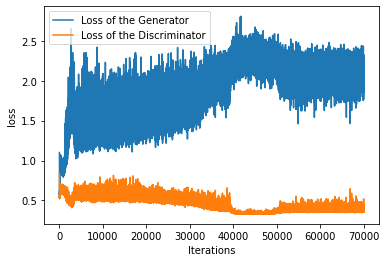

In [4]:
import matplotlib.pyplot as plt
# Plot visualization of the losses, you should pay close attention.

plt.plot(g_loss, label='Loss of the Generator')
plt.plot(d_loss, label='Loss of the Discriminator')
plt.xlabel('Iterations')
plt.ylabel('loss')
plt.legend()
plt.show()

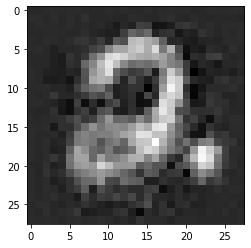

In [5]:
# Testing
# Generate images from a latent random variable, using the generator network.
# first we will create an empty np.array with the size of 28x28 
canvas = np.empty((28, 28))

# We will generate the latent random variable drawing from the uniform distribution in [-1, 1] as a 1x100 tensor
#z = np.random.uniform(-1., 1., size=[1, 100])
n = 9
z = np.random.normal(size=(n, noise_dim))


g = generator.predict(z)

# The generated sample is reshaped and visualized.
canvas[0:28, 0:28] = g[0].reshape([28, 28])

plt.figure()
plt.imshow(canvas, cmap="gray")
plt.show()

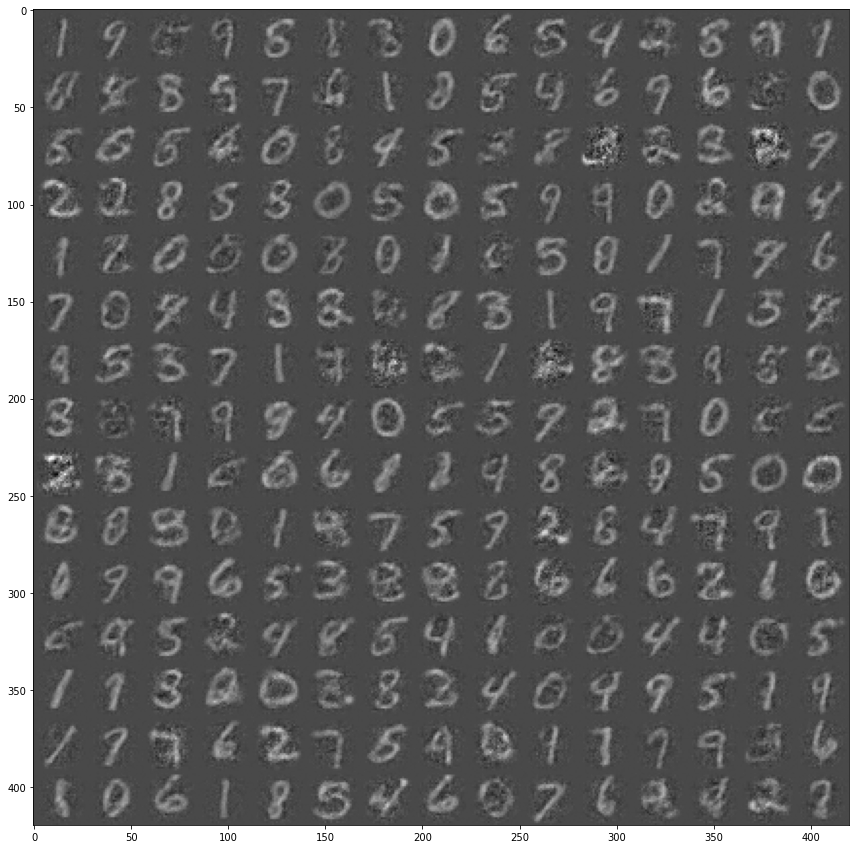

In [6]:
# Generate n*n images from noise, using the generator network.
n = 15
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    #z = np.random.uniform(-1., 1., size=[n, noise_dim])
    # Generate image from noise.
    #g = sess.run(generator(gen_input), feed_dict={gen_input: z})
    z = np.random.normal(size=(n, noise_dim))
    # Generate image from noise.
    g = generator.predict(z)
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()